In [1]:
import numpy as np
 
print("My numpy version is: ", np.__version__)

My numpy version is:  1.26.4


In [6]:


tf.__version__

'2.10.1'

In [16]:
pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\yeuvi\anaconda3\envs\py310\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install numpy==1.24

   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ------- -------------------------------- 2.9/14.8 MB 16.7 MB/s eta 0:00:01
   ---------------------- ----------------- 8.4/14.8 MB 21.7 MB/s eta 0:00:01
   --------------------------------- ------ 12.3/14.8 MB 20.8 MB/s eta 0:00:01
   ---------------------------------------- 14.8/14.8 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D


In [2]:
# Definition of the data column in protocol file
# These are by any strings, they are just names of the column in dataFrame
# There is no need to change these

# column for trial name
df_name_trial = 'trial'
# column for key (bonafide/spoof)
df_name_label = 'label'
# column for the (w/ non-speech and w/o non-speech)
df_name_trim = 'trim'
# column for subset (progress, eval, hidden, ...)
df_name_subset = 'subset'
# column for score
df_name_score  = 'score'
# column for compression
df_name_compr = 'compression'
# column for data source
df_name_source = 'source'
# column for vocoder type
df_name_vocoder = 'vocoder'
# column for spoofing attack
df_name_attack = 'attack'
# column for speaker ID
df_name_speaker = 'speaker'


# value of the pooled condition
df_pooled_tag = 'Pooled'

# ====
# For loading key and meta labels
# ====
# names of column to load protocol file
# the order of column should not be changed
df_protocol_names = [df_name_speaker,df_name_trial,
                     df_name_compr, df_name_source, df_name_attack, df_name_label,
                     df_name_trim, df_name_subset, df_name_vocoder, 
                     'task', 'team', 'gender-pair', 'language']

In [3]:
def load_protocol_21(protocol_file, names, sep=' ', index_col=None):
    pd_protocol = pd.read_csv(protocol_file, sep=' ', names=names, 
                                  index_col = index_col, skipinitialspace=True)
    return pd_protocol

In [4]:
df_protocol_file = 'C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/DF-keys-full.tar/keys/DF/CM/trial_metadata.txt'
df_protocol_pd = load_protocol_21(df_protocol_file, names = df_protocol_names, index_col = df_name_trial)
df_protocol_pd

,speaker,compression,source,attack,label,trim,subset,vocoder,task,team,gender-pair,language
trial,,,,,,,,,,,,
DF_E_2000011,LA_0023,nocodec,asvspoof,A14,spoof,notrim,progress,traditional_vocoder,-,-,-,-
DF_E_2000013,TEF2,low_m4a,vcc2020,Task1-team20,spoof,notrim,eval,neural_vocoder_nonautoregressive,Task1,team20,FF,E
DF_E_2000024,TGF1,mp3m4a,vcc2020,Task2-team12,spoof,notrim,eval,traditional_vocoder,Task2,team12,FF,G
DF_E_2000026,LA_0043,mp3m4a,asvspoof,A09,spoof,notrim,eval,traditional_vocoder,-,-,-,-
DF_E_2000027,LA_0021,mp3m4a,asvspoof,A12,spoof,notrim,eval,neural_vocoder_autoregressive,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...
DF_E_4999945,VCC2TM2,oggm4a,vcc2018,SPO-N16,spoof,notrim,eval,traditional_vocoder,SPO,N16,FM,-
DF_E_4999962,LA_0044,oggm4a,asvspoof,A19,spoof,trim,hidden,traditional_vocoder,-,-,-,-
DF_E_4999964,LA_0042,high_ogg,asvspoof,A13,spoof,notrim,eval,traditional_vocoder,-,-,-,-


In [5]:
df_protocol_pd['label'].value_counts().sort_index()

label
bonafide     22617
spoof       589212
Name: count, dtype: int64

In [6]:
# Load the exists audio file
def load_protocol_21(protocol_file, names, sep=' ', index_col=None):
    return pd.read_csv(protocol_file, sep=sep, names=names, index_col=index_col, skipinitialspace=True)

# Paths
df_protocol_file = 'C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/DF-keys-full.tar/keys/DF/CM/trial_metadata.txt'
base_path = 'C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/'

# Column names
# df_protocol_names = ['trial', 'speaker_id', 'utt_id', 'spoof_type', 'label']
df_name_trial = 'trial'


# Load protocol
df_protocol_pd = load_protocol_21(df_protocol_file, names=df_protocol_names, index_col=df_name_trial)

# Add audio path
df_protocol_pd['audio_path'] = df_protocol_pd.index.to_series().apply(lambda x: f'{base_path}{x}.flac')
df_protocol_pd = df_protocol_pd[df_protocol_pd['audio_path'].apply(os.path.exists)]

# Map labels
label_mapping = {'bonafide': 0, 'spoof': 1}
df_protocol_pd['label_num'] = df_protocol_pd['label'].map(label_mapping)

df_protocol_pd

,speaker,compression,source,attack,label,trim,subset,vocoder,task,team,gender-pair,language,audio_path,label_num
trial,,,,,,,,,,,,,,
DF_E_2000011,LA_0023,nocodec,asvspoof,A14,spoof,notrim,progress,traditional_vocoder,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
DF_E_2000013,TEF2,low_m4a,vcc2020,Task1-team20,spoof,notrim,eval,neural_vocoder_nonautoregressive,Task1,team20,FF,E,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
DF_E_2000024,TGF1,mp3m4a,vcc2020,Task2-team12,spoof,notrim,eval,traditional_vocoder,Task2,team12,FF,G,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
DF_E_2000026,LA_0043,mp3m4a,asvspoof,A09,spoof,notrim,eval,traditional_vocoder,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
DF_E_2000027,LA_0021,mp3m4a,asvspoof,A12,spoof,notrim,eval,neural_vocoder_autoregressive,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DF_E_2749666,VCC2TM2,low_ogg,vcc2018,HUB-D05,spoof,notrim,eval,traditional_vocoder,HUB,D05,MM,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
DF_E_2749668,VCC2TF2,high_ogg,vcc2018,SPO-N12,spoof,notrim,eval,traditional_vocoder,SPO,N12,FF,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
DF_E_2749677,LA_0021,low_mp3,asvspoof,A15,spoof,trim,hidden,neural_vocoder_autoregressive,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1


In [7]:
df_protocol_pd['label'].value_counts().sort_index()

label
bonafide      5535
spoof       147420
Name: count, dtype: int64

In [8]:
# Keep only 1k bonafide and 1k spoof
bonafide_df = df_protocol_pd[df_protocol_pd['label'] == 'bonafide'].sample(5535, random_state=42)
spoof_df = df_protocol_pd[df_protocol_pd['label'] == 'spoof'].sample(9000, random_state=42)

df_small = pd.concat([bonafide_df, spoof_df])
df_small = df_small.sample(frac=1).reset_index(drop=True)  # Shuffle

df_small

,speaker,compression,source,attack,label,trim,subset,vocoder,task,team,gender-pair,language,audio_path,label_num
0,LA_0041,low_m4a,asvspoof,A17,spoof,notrim,eval,traditional_vocoder,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
1,LA_0051,high_mp3,asvspoof,-,bonafide,notrim,progress,bonafide,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,0
2,VCC2TF2,nocodec,vcc2018,SPO-N03,spoof,notrim,eval,unknown,SPO,N03,FF,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
3,VCC2SF2,high_m4a,vcc2018,-,bonafide,notrim,eval,bonafide,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,0
4,VCC2TF2,low_m4a,vcc2018,HUB-N06,spoof,notrim,eval,traditional_vocoder,HUB,N06,MF,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14530,TEF1,high_mp3,vcc2020,Task1-team27,spoof,notrim,eval,neural_vocoder_nonautoregressive,Task1,team27,MF,E,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
14531,LA_0016,low_ogg,asvspoof,A11,spoof,trim,hidden,traditional_vocoder,-,-,-,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
14532,VCC2TF1,high_mp3,vcc2018,HUB-N15,spoof,notrim,eval,traditional_vocoder,HUB,N15,FF,-,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1
14533,TEM1,mp3m4a,vcc2020,Task1-team12,spoof,notrim,eval,traditional_vocoder,Task1,team12,MM,E,C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem...,1


In [9]:
import librosa

def feature_extraction(path):
  '''
  Generate different audio file features using librosa
  inputs: list of audio files to extract from
  path: path to .flac files
  returns: columns of each newly created feature   inputs,
  '''
  # assert isinstance(inputs, list)
  
  # if len(inputs) == 0:
  #   return 
  
  # name_ = os.path.join(os.path.abspath(path)+'/'+str(files.file))
  
  # load audio files in, per librosa docs these come in as a floating point time series
# X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
  
  # Mel-frequency cepstral coefficients
  # https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8
  signal, sr = librosa.load(path, sr=16000)  # Load audio at 16kHz
  feature_mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=15)
  
#   #https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
#   # http://labrosa.ee.columbia.edu/matlab/chroma-ansyn/
#   stft = np.abs(librosa.stft(X))
#   chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  
#   #https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
#   #https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/audio_processing/spectrogram.html
#   mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
  
#   # https://www.ese.wustl.edu/~nehorai/paper/specom03.pdf
#   contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
  
#   # https://repositorio.inesctec.pt/bitstream/123456789/3897/1/P-00K-KKF.pdf
#   # needs to be feed the harmonic elements from the time series
#   tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
#   sr=sample_rate).T,axis=0)tonnetz,contrast,mel,chroma,stft
  
  return feature_mfccs

In [ ]:
def librosa_feature_extraction(path):
  '''
  Generate different audio file features using librosa
  inputs: list of audio files to extract from
  path: path to .flac files
  returns: columns of each newly created feature
  '''
  # assert isinstance(inputs, list)
  
  # if len(inputs) == 0:
  #   return 
  
  # name_ = os.path.join(os.path.abspath(path)+'/'+str(files.file))
  
  # load audio files in, per librosa docs these come in as a floating point time series
  X, sample_rate = librosa.load(path, res_type='kaiser_fast')
  
  # Mel-frequency cepstral coefficients
  # https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8
  mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
  
  #https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
  # http://labrosa.ee.columbia.edu/matlab/chroma-ansyn/
  stft = np.abs(librosa.stft(X))
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  
  #https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
  #https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/audio_processing/spectrogram.html
  mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
  
  # https://www.ese.wustl.edu/~nehorai/paper/specom03.pdf
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
  
  # https://repositorio.inesctec.pt/bitstream/123456789/3897/1/P-00K-KKF.pdf
  # needs to be feed the harmonic elements from the time series
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
  
  return tonnetz, contrast, mel, chroma, stft, mfccs


Function of Melspectrogram feature extraction 

In [9]:

def melspectogram_feature_extraction(path):
    try:
        signal, sr = librosa.load(path, sr=16000)
        
        # Ensure audio is at least 1 second long
        if len(signal) < sr:
            signal = np.pad(signal, (0, sr - len(signal)))
        else:
            signal = signal[:sr]  # Trim to 1 second for consistency

        # Extract 15 MFCC features and return mean over time
        feature_melspec = librosa.feature.melspectrogram(y=signal, sr=sr)
        mel = np.mean(feature_melspec.T,axis=0)

        return mel  

    except Exception as e:
        print(f"Error extracting melspectogram features from {path}: {e}")
        return None

Melspectogram feature extraction (small dataset)

In [ ]:
#Latest (can run) - Melspectogram feature extraction for the small dataset

mel_features_small = []
mel_labels_small = []

#df_subset = df_small.sample(n=1000, random_state=42)

start_time = time.time()  # Start the timer

for idx, row in tqdm(df_small.iterrows(), total=len(df_small), desc="Extracting features"):
    path = row['audio_path']
    label = row['label_num']
    
    feature_mel = melspectogram_feature_extraction(path)

    if feature_mel is not None :  #and feature_mf.shape == (15,)
        mel_features_small.append(feature_mel)
        mel_labels_small.append(label)
    else:
        print(f"Skipped {path} due to invalid feature shape.")

# Convert to NumPy array
if mel_features_small:
    X_mel = np.stack(mel_features_small)
    y_mel = np.array(mel_labels_small)
    print(f"Extracted feature shape: {X_mel.shape}, Labels shape: {y_mel.shape}")
else:
    print("No valid features extracted.")


# End the timer
end_time = time.time()
duration = end_time - start_time

# Print duration
print(f"Melspectogram feature extraction of small dataset completed in {duration:.2f} seconds.")

Extracting features:   0%|          | 0/14535 [00:00<?, ?it/s]c:\Users\yeuvi\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\yeuvi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\yeuvi\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Extracting features:   0%|          | 1/14535 [00:03<14:48:46,  3.67s/it]C:\Users\yeuvi\AppData\Local\Temp\ipykernel_44232\370147107.py:3: 

Extracted feature shape: (14535, 128), Labels shape: (14535,)
Melspectogram feature extraction of small dataset completed in 612.91 seconds.


Data Splitting (Mel & Small Dataset)

In [ ]:
# Split into training and validation sets (MFCC features - small dataset)
X_mel_small_train, X_mel_small_val, y_mel_small_train, y_mel_small_val = train_test_split(X_mel_small, y_mel_small, test_size=0.2, stratify=y, random_state=42)

# Print shapes to verify
print(f"X_mel_small_train shape: {X_mel_small_train.shape}, X_mel_small_val shape: {X_mel_small_val.shape}")
print(f"y_mel_small_train shape: {y_mel_small_train.shape}, y_mel_small_val shape: {y_mel_small_val.shape}")

Melspectogram features extraction (Whole Dataset)

In [ ]:
#Latest (can run) - melspectogram feature extraction for the whole dataset

mel_features_whole = []
mel_labels_whole = []

#df_subset = df_small.sample(n=1000, random_state=42)

start_time = time.time()  # Start the timer

for idx, row in tqdm(df_protocol_pd.iterrows(), total=len(df_protocol_pd), desc="Extracting features"):
    path = row['audio_path']
    label = row['label_num']
    
    feature_mel_whole = melspectogram_feature_extraction(path)

    if feature_mel_whole is not None :  #and feature_mf.shape == (15,)
        mel_features_whole.append(feature_mel_whole)
        mel_labels_whole.append(label)
    else:
        print(f"Skipped {path} due to invalid feature shape.")

# Convert to NumPy array
if mel_features_whole:
    X_mel_whole = np.stack(mel_features_whole)
    y_mel_whole = np.array(mel_labels_whole)
    print(f"Extracted feature shape: {X_mel_whole.shape}, Labels shape: {y_mel_whole.shape}")
else:
    print("No valid features extracted.")


# End the timer
end_time = time.time()
duration = end_time - start_time

# Print duration
print(f"Melspectogram feature extraction of whole dataset completed in {duration:.2f} seconds.")

Extracting features:   0%|          | 0/152955 [00:00<?, ?it/s]C:\Users\yeuvi\AppData\Local\Temp\ipykernel_26604\370147107.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=16000)
Extracting features: 100%|██████████| 152955/152955 [1:51:09<00:00, 22.93it/s]  

Extracted feature shape: (152955, 128), Labels shape: (152955,)
Melspectogram feature extraction of small dataset completed in 6670.14 seconds.


Data Splitting (Mel & Whole Dataset)

In [ ]:
# Split into training and validation sets (MFCC features - small dataset)
X_mel_whole_train, X_mel_whole_val, y_mel_whole_train, y_mel_whole_val = train_test_split(X_mel_whole, y_mel_whole, test_size=0.2, stratify=y, random_state=42)

# Print shapes to verify
print(f"X_mel_whole_train shape: {X_mel_whole_train.shape}, X_mel_whole_val shape: {X_mel_whole_val.shape}")
print(f"y_mel_whole_train shape: {y_mel_whole_train.shape}, y_mel_whole_val shape: {y_mel_whole_val.shape}")

Function of MFCC feature extraction 

In [16]:
#Latest (can run)

def mfcc_feature_extraction(path):
    try:
        signal, sr = librosa.load(path, sr=16000)
        
        # Ensure audio is at least 1 second long
        if len(signal) < sr:
            signal = np.pad(signal, (0, sr - len(signal)))
        else:
            signal = signal[:sr]  # Trim to 1 second for consistency

        # Extract 15 MFCC features and return mean over time
        feature_ccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=15)
        mfccs_mean = np.mean(feature_ccs.T, axis=0)

        return mfccs_mean  # Shape: (15,)

    except Exception as e:
        print(f"Error extracting features from {path}: {e}")
        return None

MFCC feature extraction (Small dataset)

In [ ]:
#Latest (can run) - feature extraction for the small dataset

mfcc_features_small = []
mfcc_labels_small = []

#df_subset = df_small.sample(n=1000, random_state=42)

start_time = time.time()  # Start the timer

for idx, row in tqdm(df_small.iterrows(), total=len(df_small), desc="Extracting features"):
    path = row['audio_path']
    label = row['label_num']
    
    feature_mf_small = mfcc_feature_extraction(path)

    if feature_mf_small is not None and feature_mf_small.shape == (15,):
        mfcc_features_small.append(feature_mf_small)
        mfcc_labels_small.append(label)
    else:
        print(f"Skipped {path} due to invalid feature shape.")

# Convert to NumPy array
if mfcc_features_small:
    X_mfcc_small = np.stack(mfcc_features_small)
    y_mfcc_small = np.array(mfcc_labels_small)
    print(f"Extracted feature shape: {X_mfcc_small.shape}, Labels shape: {y_mfcc_small.shape}")
else:
    print("No valid features extracted.")


# End the timer
end_time = time.time()
duration = end_time - start_time

# Print duration
print(f"MFCC feature extraction of small dataset completed in {duration:.2f} seconds.")

Extracting features:   0%|          | 0/14535 [00:00<?, ?it/s]C:\Users\yeuvi\AppData\Local\Temp\ipykernel_44232\123283099.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=16000)
Extracting features: 100%|██████████| 14535/14535 [08:18<00:00, 29.15it/s]

Extracted feature shape: (14535, 15), Labels shape: (14535,)
MFCC feature extraction of small dataset completed in 498.57 seconds.


Dataset splitting (MFCC & Small Dataset)

In [ ]:
# Split into training and validation sets (MFCC features - small dataset)
X_mfcc_small_train, X_mfcc_small_val, y_mfcc_small_train, y_mfcc_small_val = train_test_split(X_mfcc_small, y_mfcc_small, test_size=0.2, stratify=y, random_state=42)

# Print shapes to verify
print(f"X_mfcc_small_train shape: {X_mfcc_small_train.shape}, X_mfcc_small_val shape: {X_mfcc_small_val.shape}")
print(f"y_mfcc_small_train shape: {y_mfcc_small_train.shape}, y_mfcc_small_val shape: {y_mfcc_small_val.shape}")

X_mfcc_train shape: (11628, 15), X_mfcc_val shape: (2907, 15)
y_mfcc_train shape: (11628,), y_mfcc_val shape: (2907,)


MFCC feature extraction (Whole dataset)

In [ ]:
#Latest (can run) - feature extraction for the whole dataset

mfcc_features_whole = []
mfcc_labels_whole = []

#df_subset = df_small.sample(n=1000, random_state=42)

for idx, row in tqdm(df_protocol_pd.iterrows(), total=len(df_protocol_pd), desc="Extracting features"):
    path = row['audio_path']
    label = row['label_num']
    
    feature_mf_whole = mfcc_feature_extraction(path)

    if feature_mf_whole is not None and feature_mf_whole.shape == (15,):
        mfcc_features_whole.append(feature_mf)
        mfcc_labels_whole.append(label)
    else:
        print(f"Skipped {path} due to invalid feature shape.")

# Convert to NumPy array
if features:
    X_mfcc_whole = np.stack(mfcc_features_whole)
    y_mfcc_whole = np.array(mfcc_labels_whole)
    print(f"Extracted feature shape: {X_mfcc_whole.shape}, Labels shape: {y_mfcc_whole.shape}")
else:
    print("No valid features extracted.")

Extracting features:   0%|          | 0/152955 [00:00<?, ?it/s]

C:\Users\yeuvi\AppData\Local\Temp\ipykernel_27072\1917248033.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=16000)
c:\Users\yeuvi\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting features: 100%|██████████| 152955/152955 [1:48:06<00:00, 23.58it/s]  


Extracted feature shape: (152955, 15), Labels shape: (152955,)


Data Splitting (MFCC & Whole dataset)

In [ ]:
# Split into training and validation sets
X_mfcc_whole_train, X_mfcc_whole_val, y_mfcc_whole_train, y_mfcc_whole_val = train_test_split(X_mfcc_whole, y_mfcc_whole, test_size=0.2, stratify=y2, random_state=42)

# Print shapes to verify
print(f"X_mfcc_whole_train shape: {X_mfcc_whole_train.shape}, X_mfcc_whole_val shape: {X_mfcc_whole_val.shape}")
print(f"y_mfcc_whole_train shape: {y_mfcc_whole_train.shape}, y_mfcc_whole_val shape: {y_mfcc_whole_val.shape}")

X2_train shape: (122364, 128), X2_val shape: (30591, 128)
y2_train shape: (122364,), y2_val shape: (30591,)


SUPPORT VECTOR MACHINE (SVM) training (Mel & Small Dataset)

In [ ]:
# Train the SVM model (Melspectogram & small dataset)
svm_model_mel_small = SVC(kernel='linear', random_state=42)
svm_model_mel_small.fit(X_mel_small_train, y_mel_small_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predict the target for the test set
y_svm_mel_small_pred = svm_model.predict(X_val)

# Evaluate the model
accuracy_svm_mel_small = accuracy_score(y_mel_small_val, y_svm_mel_small_pred)
classification_rep_svm_mel_small = classification_report(y_mel_small_val, y_svm_mel_small_pred)
conf_matrix_svm_mel_small = confusion_matrix(y_mel_small_val, y_svm_mel_small_pred)

# Display the evaluation results
print(f'Accuracy of using SVM model with melspectogram features (Small Dataset): {accuracy_svm_mel_small}')
print('Classification Report SVM (Melspectogram & Small Dataset):')
print(classification_rep_svm_mel_small)

Accuracy: 0.7650498796009632
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1107
           1       0.79      0.85      0.82      1800

    accuracy                           0.77      2907
   macro avg       0.75      0.74      0.74      2907
weighted avg       0.76      0.77      0.76      2907



SUPPORT VECTOR MACHINE (SVM) training (MFCC & Small Dataset)

In [ ]:
# Train the SVM model (MFCC & small dataset))
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_mfcc_small_train, y_mfcc_small_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predict the target for the test set
y_svm_mfcc_small_pred = svm_model.predict(X_mfcc_small_val)

# Evaluate the model
accuracy_svm_mfcc_small = accuracy_score(y_mfcc_val, y_svm_mfcc_small_pred)
classification_rep_svm_mfcc_small = classification_report(y_mfcc_val, y_svm_mfcc_small_pred)
conf_matrix_svm_mfcc_small = confusion_matrix(y_mfcc_val, y_svm_mfcc_small_pred)

# Display the evaluation results
print(f'Accuracy of SVM model with MFCC features (Small Dataset): {accuracy_svm_mfcc_small}')
print('Classification Report SVM (MFCC & Small Dataset):')
print(classification_rep_svm_mfcc_small)

Accuracy SVM (MFCC): 0.8166494668042655
Classification Report SVM (MFCC):
              precision    recall  f1-score   support

           0       0.84      0.64      0.73      1107
           1       0.81      0.93      0.86      1800

    accuracy                           0.82      2907
   macro avg       0.82      0.78      0.79      2907
weighted avg       0.82      0.82      0.81      2907



BiLSTM model

In [12]:
# Model 1 (Testing 1)

# Parameters
target_sr = 16000
target_len = 4 * target_sr  # 4 seconds (64000 samples)

model1 = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(target_len, 1)), #1
    Bidirectional(LSTM(100, return_sequences=True)), #2
    Bidirectional(LSTM(64, return_sequences=True)), #3
    Bidirectional(LSTM(64, return_sequences=True)), #4
    Bidirectional(LSTM(32, return_sequences=True)), #5
    # Bidirectional(LSTM(100, return_sequences=True)), #6
    # Bidirectional(LSTM(100, return_sequences=True)), #7
    # Bidirectional(LSTM(100, return_sequences=True)), #8
    # Bidirectional(LSTM(100, return_sequences=True)), #9
    Bidirectional(LSTM(16, return_sequences=False)), #10
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use softmax for multi-class
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

c:\Users\yeuvi\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64000, 200)     │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64000, 200)     │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64000, 128)     │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64000, 128)     │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64000, 64)      │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,657 (2.33 MB)

 Trainable params: 610,657 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Model 1 training_Melspectogram (Small dataset)

history_mel_small = model1.fit(X_mfcc_train, y_mfcc_train, validation_data=(X_mfcc_val, y_mfcc_val), epochs=35, batch_size=64)

Epoch 1/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.7834 - loss: 0.5190 - val_accuracy: 0.7964 - val_loss: 0.4763
Epoch 2/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7997 - loss: 0.4754 - val_accuracy: 0.8025 - val_loss: 0.4731
Epoch 3/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8016 - loss: 0.4771 - val_accuracy: 0.8056 - val_loss: 0.4658
Epoch 4/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8150 - loss: 0.4576 - val_accuracy: 0.8108 - val_loss: 0.4566
Epoch 5/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8163 - loss: 0.4561 - val_accuracy: 0.8105 - val_loss: 0.4648
Epoch 6/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8112 - loss: 0.4581 - val_accuracy: 0.8173 - val_loss: 0.4468
Epoch 7/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8099 - loss: 0.4571 - val_accuracy: 0.8125 - val_loss: 0.4556
Epoch 8/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8259 - loss: 0.4371 - val_acc

In [ ]:
#Model 1 training_MFCC (Small dataset)

history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35, batch_size=64)

Epoch 1/35


182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.7622 - loss: 0.5182 - val_accuracy: 0.8015 - val_loss: 0.4695
Epoch 2/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7951 - loss: 0.4849 - val_accuracy: 0.8025 - val_loss: 0.4749
Epoch 3/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8000 - loss: 0.4812 - val_accuracy: 0.8039 - val_loss: 0.4656
Epoch 4/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8038 - loss: 0.4693 - val_accuracy: 0.8074 - val_loss: 0.4574
Epoch 5/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8186 - loss: 0.4468 - val_accuracy: 0.8129 - val_loss: 0.4529
Epoch 6/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8100 - loss: 0.4526 - val_accuracy: 0.8084 - val_loss: 0.4615
Epoch 7/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8118 - loss: 0.4526 - val_accuracy: 0.8232 - val_loss: 0.4438
Epoch 8/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8276 - loss: 0.4298 - val_accuracy: 0.81

In [ ]:
#Model 1 training_MFCC (full dataset) 

history1_2 = model1.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=15, batch_size=128)

Epoch 1/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 69s 72ms/step - accuracy: 0.9705 - loss: 0.0807 - val_accuracy: 0.9744 - val_loss: 0.0665
Epoch 2/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step - accuracy: 0.9783 - loss: 0.0574 - val_accuracy: 0.9729 - val_loss: 0.0732
Epoch 3/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 75s 79ms/step - accuracy: 0.9797 - loss: 0.0538 - val_accuracy: 0.9764 - val_loss: 0.0683
Epoch 4/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.9807 - loss: 0.0524 - val_accuracy: 0.9767 - val_loss: 0.0690
Epoch 5/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 84s 88ms/step - accuracy: 0.9824 - loss: 0.0485 - val_accuracy: 0.9757 - val_loss: 0.0724
Epoch 6/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 73s 76ms/step - accuracy: 0.9843 - loss: 0.0455 - val_accuracy: 0.9747 - val_loss: 0.0784
Epoch 7/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 70s 73ms/step - accuracy: 0.9856 - loss: 0.0400 - val_accuracy: 0.9773 - val_loss: 0.0704
Epoch 8/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.9871 - loss: 0.0370 - 

In [45]:
# Make predictions

model1_y2_pred_probs = model1.predict(X2_val)
model1_y2_pred = (model1_y2_pred_probs >= 0.5).astype(int)

956/956 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


In [ ]:
#Data of perdiciton checking (Make sure it is binary)

model1_y2_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [47]:
# Evaluate the model
model1_accuracy = accuracy_score(y2_val, model1_y2_pred)
print("Accuracy:", model1_accuracy)
print("\nClassification Report:")
print(classification_report(y2_val, model1_y2_pred))

Accuracy: 0.9818247196887974

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1107
           1       0.99      0.99      0.99     29484

    accuracy                           0.98     30591
   macro avg       0.90      0.82      0.86     30591
weighted avg       0.98      0.98      0.98     30591



In [48]:
# Print the Confusion Matrix and slice it into four pieces

model1_cm = confusion_matrix(y2_val, model1_y2_pred)

print('Confusion matrix\n\n', model1_cm)

print('\nTrue Positives(TP) = ', model1_cm[0,0])

print('\nTrue Negatives(TN) = ', model1_cm[1,1])

print('\nFalse Positives(FP) = ', model1_cm[0,1])

print('\nFalse Negatives(FN) = ', model1_cm[1,0])

Confusion matrix

 [[  721   386]
 [  170 29314]]

True Positives(TP) =  721

True Negatives(TN) =  29314

False Positives(FP) =  386

False Negatives(FN) =  170


<Axes: >

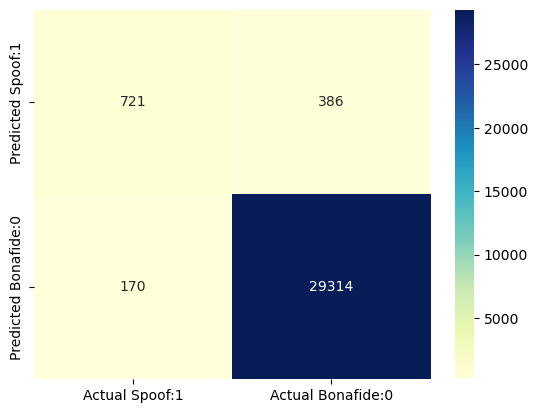

In [53]:
# visualize confusion matrix with seaborn heatmap

# bonafide = 0, spoof = 1

model1_cm_matrix = pd.DataFrame(data=model1_cm, columns=['Actual Spoof:1', 'Actual Bonafide:0'], 
                                 index=['Predicted Spoof:1', 'Predicted Bonafide:0'])

sns.heatmap(model1_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [33]:
# Model 2 (Testin 2)

# Parameters
target_sr = 16000
target_len = 4 * target_sr  # 4 seconds (64000 samples)

model2 = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(target_len, 1)), #1
    Bidirectional(LSTM(100, return_sequences=True)), #2
    Bidirectional(LSTM(64, return_sequences=True)), #3
    Bidirectional(LSTM(32, return_sequences=True)), #4
    Bidirectional(LSTM(32, return_sequences=True)), #5
    # Bidirectional(LSTM(100, return_sequences=True)), #6
    # Bidirectional(LSTM(100, return_sequences=True)), #7
    # Bidirectional(LSTM(100, return_sequences=True)), #8
    # Bidirectional(LSTM(100, return_sequences=True)), #9
    Bidirectional(LSTM(16, return_sequences=False)), #10
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use softmax for multi-class
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

c:\Users\yeuvi\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_48                │ (None, 64000, 128)     │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_49                │ (None, 64000, 200)     │       183,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_50                │ (None, 64000, 128)     │       135,680 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_51                │ (None, 64000, 64)      │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_52                │ (None, 64000, 64)      │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_53                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,265 (1.65 MB)

 Trainable params: 431,265 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Model 2 training 

history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35, batch_size=64)

Epoch 1/35


182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9447 - loss: 0.2019 - val_accuracy: 0.9512 - val_loss: 0.1471
Epoch 2/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9613 - loss: 0.1257 - val_accuracy: 0.9501 - val_loss: 0.1586
Epoch 3/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9657 - loss: 0.1098 - val_accuracy: 0.9518 - val_loss: 0.1564
Epoch 4/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9720 - loss: 0.0870 - val_accuracy: 0.9518 - val_loss: 0.1724
Epoch 5/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9805 - loss: 0.0687 - val_accuracy: 0.9467 - val_loss: 0.1783
Epoch 6/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9777 - loss: 0.0695 - val_accuracy: 0.9439 - val_loss: 0.1750
Epoch 7/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9797 - loss: 0.0634 - val_accuracy: 0.9357 - val_loss: 0.2279
Epoch 8/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9770 - loss: 0.0640 - val_accuracy: 0.949

In [64]:
#Model 2 training (full dataset)

history2_2 = model2.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=15, batch_size=128)

Epoch 1/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 76s 63ms/step - accuracy: 0.9574 - loss: 0.1550 - val_accuracy: 0.9638 - val_loss: 0.1202
Epoch 2/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step - accuracy: 0.9638 - loss: 0.1212 - val_accuracy: 0.9638 - val_loss: 0.1173
Epoch 3/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.9634 - loss: 0.1177 - val_accuracy: 0.9638 - val_loss: 0.1157
Epoch 4/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step - accuracy: 0.9650 - loss: 0.1116 - val_accuracy: 0.9682 - val_loss: 0.1103
Epoch 5/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.9675 - loss: 0.1118 - val_accuracy: 0.9678 - val_loss: 0.1102
Epoch 6/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.9701 - loss: 0.1063 - val_accuracy: 0.9686 - val_loss: 0.1062
Epoch 7/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.9705 - loss: 0.1013 - val_accuracy: 0.9681 - val_loss: 0.1069
Epoch 8/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.9718 - loss: 0.1001 - 

In [65]:
# Make predictions (Model 2)

model2_y2_pred_probs = model2.predict(X2_val)
model2_y2_pred = (model2_y2_pred_probs >= 0.5).astype(int)

956/956 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


In [66]:
# Evaluate the model (Model 2)

model2_accuracy = accuracy_score(y2_val, model2_y2_pred)
print("Accuracy:", model2_accuracy)
print("\nClassification Report:")
print(classification_report(y2_val, model2_y2_pred))

Accuracy: 0.974273479127848

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.44      0.55      1107
           1       0.98      0.99      0.99     29484

    accuracy                           0.97     30591
   macro avg       0.86      0.72      0.77     30591
weighted avg       0.97      0.97      0.97     30591



In [67]:
# Print the Confusion Matrix and slice it into four pieces  (Model 2)

model2_cm = confusion_matrix(y2_val, model1_y2_pred)

print('Confusion matrix\n\n', model2_cm)

print('\nTrue Positives(TP) = ', model2_cm[0,0])

print('\nTrue Negatives(TN) = ', model2_cm[1,1])

print('\nFalse Positives(FP) = ', model2_cm[0,1])

print('\nFalse Negatives(FN) = ', model2_cm[1,0])

Confusion matrix

 [[  721   386]
 [  170 29314]]

True Positives(TP) =  721

True Negatives(TN) =  29314

False Positives(FP) =  386

False Negatives(FN) =  170


<Axes: >

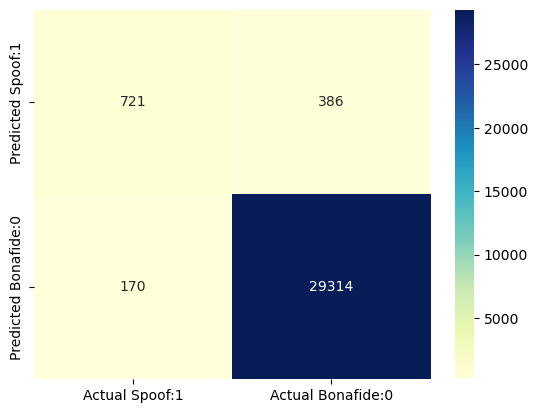

In [68]:
# visualize confusion matrix with seaborn heatmap (Model 2)

# bonafide = 0, spoof = 1

model2_cm_matrix = pd.DataFrame(data=model2_cm, columns=['Actual Spoof:1', 'Actual Bonafide:0'], 
                                 index=['Predicted Spoof:1', 'Predicted Bonafide:0'])

sns.heatmap(model2_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [28]:
# Model 3 (Testin 3)

# Parameters
target_sr = 16000
target_len = 4 * target_sr  # 4 seconds (64000 samples)

model3 = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(target_len, 1)), #1
    Bidirectional(LSTM(64, return_sequences=True)), #2
    Bidirectional(LSTM(100, return_sequences=True)), #3
    Bidirectional(LSTM(100, return_sequences=True)), #4
    Bidirectional(LSTM(64, return_sequences=True)), #5
    Bidirectional(LSTM(32, return_sequences=True)), #6
    # Bidirectional(LSTM(100, return_sequences=True)), #7
    # Bidirectional(LSTM(100, return_sequences=True)), #8
    # Bidirectional(LSTM(100, return_sequences=True)), #9
    Bidirectional(LSTM(16, return_sequences=False)), #10
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use softmax for multi-class
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

c:\Users\yeuvi\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_41                │ (None, 64000, 64)      │         8,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ (None, 64000, 128)     │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ (None, 64000, 200)     │       183,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_45                │ (None, 64000, 128)     │       135,680 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ (None, 64000, 64)      │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,193 (2.63 MB)

 Trainable params: 688,193 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Model 3 training 

history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35, batch_size=64)

Epoch 1/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.7566 - loss: 0.5320 - val_accuracy: 0.8015 - val_loss: 0.4773
Epoch 2/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8061 - loss: 0.4765 - val_accuracy: 0.7943 - val_loss: 0.4837
Epoch 3/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8089 - loss: 0.4700 - val_accuracy: 0.8084 - val_loss: 0.4633
Epoch 4/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8140 - loss: 0.4570 - val_accuracy: 0.8132 - val_loss: 0.4523
Epoch 5/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8135 - loss: 0.4568 - val_accuracy: 0.8201 - val_loss: 0.4464
Epoch 6/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8193 - loss: 0.4453 - val_accuracy: 0.8163 - val_loss: 0.4489
Epoch 7/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8172 - loss: 0.4479 - val_accuracy: 0.8187 - val_loss: 0.4441
Epoch 8/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8301 - loss: 0.4280 - 

In [58]:
#Model 3 training (full dataset) 

history3_2 = model3.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=15, batch_size=128)

Epoch 1/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.9660 - loss: 0.1036 - val_accuracy: 0.9674 - val_loss: 0.0968
Epoch 2/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 77s 80ms/step - accuracy: 0.9678 - loss: 0.0958 - val_accuracy: 0.9686 - val_loss: 0.0987
Epoch 3/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step - accuracy: 0.9701 - loss: 0.0927 - val_accuracy: 0.9697 - val_loss: 0.0933
Epoch 4/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.9699 - loss: 0.0957 - val_accuracy: 0.9680 - val_loss: 0.0960
Epoch 5/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.9713 - loss: 0.0895 - val_accuracy: 0.9698 - val_loss: 0.0959
Epoch 6/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.9726 - loss: 0.0867 - val_accuracy: 0.9691 - val_loss: 0.0998
Epoch 7/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.9731 - loss: 0.0867 - val_accuracy: 0.9709 - val_loss: 0.0941
Epoch 8/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.9755 - loss: 0.0820 - 

In [ ]:
# Make predictions (Model 3)

model3_y2_pred_probs = model3.predict(X2_val)
model3_y2_pred = (model3_y2_pred_probs >= 0.5).astype(int)

956/956 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step


In [ ]:
# Evaluate the model (Model 3)

model3_accuracy = accuracy_score(y2_val, model3_y2_pred)
print("Accuracy:", model3_accuracy)
print("\nClassification Report:")
print(classification_report(y2_val, model3_y2_pred))

Accuracy: 0.9731947304762839

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.52      0.58      1107
           1       0.98      0.99      0.99     29484

    accuracy                           0.97     30591
   macro avg       0.82      0.75      0.78     30591
weighted avg       0.97      0.97      0.97     30591



In [ ]:
# Print the Confusion Matrix and slice it into four pieces  (Model 3)

model3_cm = confusion_matrix(y2_val, model3_y2_pred)

print('Confusion matrix\n\n', model3_cm)

print('\nTrue Positives(TP) = ', model3_cm[0,0])

print('\nTrue Negatives(TN) = ', model3_cm[1,1])

print('\nFalse Positives(FP) = ', model3_cm[0,1])

print('\nFalse Negatives(FN) = ', model3_cm[1,0])

Confusion matrix

 [[  573   534]
 [  286 29198]]

True Positives(TP) =  573

True Negatives(TN) =  29198

False Positives(FP) =  534

False Negatives(FN) =  286


<Axes: >

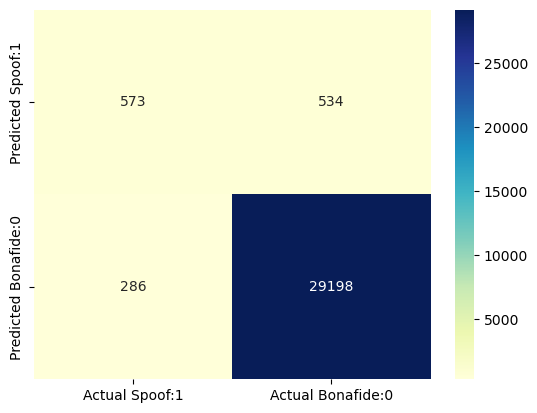

In [63]:
# visualize confusion matrix with seaborn heatmap (Model 3)

# bonafide = 0, spoof = 1

model3_cm_matrix = pd.DataFrame(data=model3_cm, columns=['Actual Spoof:1', 'Actual Bonafide:0'], 
                                 index=['Predicted Spoof:1', 'Predicted Bonafide:0'])

sns.heatmap(model3_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [17]:
# Model 4 (Testin 4)

# Parameters
target_sr = 16000
target_len = 4 * target_sr  # 4 seconds (64000 samples)

model4 = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(target_len, 1)), #1
    Bidirectional(LSTM(100, return_sequences=True)), #2
    Bidirectional(LSTM(100, return_sequences=True)), #3
    Bidirectional(LSTM(100, return_sequences=True)), #4
    Bidirectional(LSTM(100, return_sequences=True)), #5
    Bidirectional(LSTM(100, return_sequences=True)), #6
    Bidirectional(LSTM(100, return_sequences=True)), #7
    Bidirectional(LSTM(100, return_sequences=True)), #8
    Bidirectional(LSTM(100, return_sequences=True)), #9
    Bidirectional(LSTM(16, return_sequences=False)), #10
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use softmax for multi-class
])

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 64000, 200)     │        81,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 64000, 200)     │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 32)             │        27,776 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,037,953 (7.77 MB)

 Trainable params: 2,037,953 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Model 4 training (small dataset)

history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35, batch_size=64)

Epoch 1/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/step - accuracy: 0.7842 - loss: 0.5209 - val_accuracy: 0.7891 - val_loss: 0.5109
Epoch 2/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.8028 - loss: 0.4852 - val_accuracy: 0.7943 - val_loss: 0.4843
Epoch 3/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.8008 - loss: 0.4754 - val_accuracy: 0.7998 - val_loss: 0.4844
Epoch 4/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - accuracy: 0.8012 - loss: 0.4724 - val_accuracy: 0.8063 - val_loss: 0.4770
Epoch 5/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - accuracy: 0.8081 - loss: 0.4696 - val_accuracy: 0.8019 - val_loss: 0.4718
Epoch 6/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.8034 - loss: 0.4622 - val_accuracy: 0.8149 - val_loss: 0.4674
Epoch 7/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 179ms/step - accuracy: 0.8204 - loss: 0.4443 - val_accuracy: 0.8232 - val_loss: 0.4551
Epoch 8/35
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.8084 - loss: 0

In [19]:
#Model 4 training (full dataset) 

history4_2 = model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=15, batch_size=128)

Epoch 1/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 346s 362ms/step - accuracy: 0.9652 - loss: 0.0997 - val_accuracy: 0.9700 - val_loss: 0.0860
Epoch 2/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 359s 376ms/step - accuracy: 0.9709 - loss: 0.0823 - val_accuracy: 0.9702 - val_loss: 0.0858
Epoch 3/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 358s 375ms/step - accuracy: 0.9730 - loss: 0.0782 - val_accuracy: 0.9724 - val_loss: 0.0851
Epoch 4/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 345s 361ms/step - accuracy: 0.9754 - loss: 0.0738 - val_accuracy: 0.9720 - val_loss: 0.0873
Epoch 5/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 346s 362ms/step - accuracy: 0.9755 - loss: 0.0743 - val_accuracy: 0.9728 - val_loss: 0.0883
Epoch 6/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 351s 367ms/step - accuracy: 0.9754 - loss: 0.0718 - val_accuracy: 0.9750 - val_loss: 0.0840
Epoch 7/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 344s 360ms/step - accuracy: 0.9769 - loss: 0.0698 - val_accuracy: 0.9753 - val_loss: 0.0815
Epoch 8/15
956/956 ━━━━━━━━━━━━━━━━━━━━ 344s 360ms/step - accuracy: 0.9785 -

In [ ]:
# Make predictions (Model 4)

model4_y2_pred_probs = model4.predict(X2_val)
model4_y2_pred = (model4_y2_pred_probs >= 0.5).astype(int)

In [ ]:
# Evaluate the model (Model 4)

model3_accuracy = accuracy_score(y2_val, model4_y2_pred)
print("Accuracy:", model3_accuracy)
print("\nClassification Report:")
print(classification_report(y2_val, model4_y2_pred))

In [ ]:
# Print the Confusion Matrix and slice it into four pieces  (Model 3)

model4_cm = confusion_matrix(y2_val, model4_y2_pred)

print('Confusion matrix\n\n', model4_cm)

print('\nTrue Positives(TP) = ', model4_cm[0,0])

print('\nTrue Negatives(TN) = ', model4_cm[1,1])

print('\nFalse Positives(FP) = ', model4_cm[0,1])

print('\nFalse Negatives(FN) = ', model4_cm[1,0])

In [ ]:
# visualize confusion matrix with seaborn heatmap (Model 3)

# bonafide = 0, spoof = 1

model4_cm_matrix = pd.DataFrame(data=model4_cm, columns=['Actual Spoof:1', 'Actual Bonafide:0'], 
                                 index=['Predicted Spoof:1', 'Predicted Bonafide:0'])

sns.heatmap(model4_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [9]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

features = []
labels = []

df_subset = df_small.sample(n=1000, random_state=42)

for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Extracting features"):
    path = row['audio_path']
    label = row['label_num']
    
    try:
        feature_mf = feature_extraction(path)
        #combined = np.hstack([tonnetz, contrast, mel, chroma, mfccs])  # Concatenate features
        #features.append(combined)
        features.append(feature_mf)  # Append MFCCs only for simplicity
        labels.append(label)
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Convert to NumPy array
X = np.array(features)
y = np.array(labels)

print(f"Extracted feature shape: {X.shape}, Labels shape: {y.shape}")

Extracting features:   0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\yeuvi\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\yeuvi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\yeuvi\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Extracting features:   0%|          | 1/1000 [00:03<57:00,  3.42s/it]C:\Users\yeuvi\AppData\Local\Temp\ipykernel_7724\3737368629.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  sign

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1000, 15) + inhomogeneous part.

In [11]:
features = []
labels = []

# Sample a subset of the data
df_subset = df_small.sample(n=1000, random_state=42)

for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Extracting features"):
    path = row['audio_path']
    label = row['label_num']
    
    try:
        feature_mf = feature_extraction(path)

        # Make sure the output is a NumPy array of fixed size
        feature_mf = np.asarray(feature_mf)
        if feature_mf.shape != (15,):  # Adjust if your MFCCs have a different size
            print(f"Unexpected feature shape at {path}: {feature_mf.shape}")
            continue

        features.append(feature_mf)
        labels.append(label)

    except Exception as e:
        print(f"Error processing {path}: {e}")

# Final shape checks and conversion
if features:
    X = np.stack(features)  # safer than np.array when shape is fixed
    y = np.array(labels)
    print(f"Extracted feature shape: {X.shape}, Labels shape: {y.shape}")
else:
    print("❌ No features extracted. Check error logs above.")

Extracting features:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\yeuvi\AppData\Local\Temp\ipykernel_7724\3737368629.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=16000)  # Load audio at 16kHz
Extracting features:   0%|          | 3/1000 [00:00<00:50, 19.92it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2077122.flac: (15, 123)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2244303.flac: (15, 88)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2420540.flac: (15, 103)


Extracting features:   2%|▏         | 15/1000 [00:00<00:25, 38.58it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2011647.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2653449.flac: (15, 113)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2637622.flac: (15, 195)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2198644.flac: (15, 87)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2474164.flac: (15, 73)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2095083.flac: (15, 57)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2098278.flac: (15, 83)
Unexpected feature shape at C:/Users/yeuvi/Doc

Extracting features:   3%|▎         | 26/1000 [00:00<00:23, 40.74it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2380994.flac: (15, 57)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2329561.flac: (15, 97)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2576214.flac: (15, 77)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2377212.flac: (15, 74)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2461512.flac: (15, 140)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2652317.flac: (15, 121)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2202174.flac: (15, 61)
Unexpected feature shape at C:/Users/yeuvi/Doc

Extracting features:   3%|▎         | 31/1000 [00:00<00:31, 30.76it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2494452.flac: (15, 86)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2447927.flac: (15, 80)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2055447.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2498238.flac: (15, 109)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2710023.flac: (15, 61)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2715525.flac: (15, 45)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2654114.flac: (15, 89)


Extracting features:   4%|▎         | 35/1000 [00:01<00:32, 29.49it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2196400.flac: (15, 217)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2115839.flac: (15, 127)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2526298.flac: (15, 41)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2044364.flac: (15, 77)


Extracting features:   4%|▍         | 45/1000 [00:01<00:31, 30.59it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2000410.flac: (15, 87)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2389295.flac: (15, 103)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2533522.flac: (15, 111)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2241969.flac: (15, 118)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2222329.flac: (15, 135)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2393375.flac: (15, 123)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2304337.flac: (15, 110)
Unexpected feature shape at C:/Users/yeuvi

Extracting features:   5%|▍         | 49/1000 [00:01<00:32, 29.26it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2287323.flac: (15, 131)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2435861.flac: (15, 107)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2295273.flac: (15, 163)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2490394.flac: (15, 173)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2571952.flac: (15, 105)


Extracting features:   6%|▌         | 55/1000 [00:01<00:37, 24.91it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2364656.flac: (15, 57)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2122772.flac: (15, 69)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2546627.flac: (15, 111)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2367499.flac: (15, 107)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2735752.flac: (15, 44)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2574714.flac: (15, 73)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2352473.flac: (15, 46)


Extracting features:   6%|▋         | 64/1000 [00:02<00:32, 29.22it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2321541.flac: (15, 43)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2329607.flac: (15, 88)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2347847.flac: (15, 49)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2571063.flac: (15, 113)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2099958.flac: (15, 123)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2651863.flac: (15, 140)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2684609.flac: (15, 55)
Unexpected feature shape at C:/Users/yeuvi/Do

Extracting features:   7%|▋         | 74/1000 [00:02<00:28, 32.87it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2410174.flac: (15, 57)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2660786.flac: (15, 56)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2521749.flac: (15, 215)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2282103.flac: (15, 31)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2397200.flac: (15, 83)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2398003.flac: (15, 111)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2577971.flac: (15, 72)
Unexpected feature shape at C:/Users/yeuvi/Doc

Extracting features:   8%|▊         | 85/1000 [00:02<00:22, 40.23it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2115808.flac: (15, 125)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2177759.flac: (15, 69)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2214013.flac: (15, 95)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2642452.flac: (15, 74)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2612301.flac: (15, 127)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2347942.flac: (15, 134)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2222086.flac: (15, 199)
Unexpected feature shape at C:/Users/yeuvi/D

Extracting features:   9%|▉         | 90/1000 [00:02<00:31, 29.19it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2539850.flac: (15, 109)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2350864.flac: (15, 112)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2123969.flac: (15, 95)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2357981.flac: (15, 69)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2505861.flac: (15, 167)


Extracting features:   9%|▉         | 94/1000 [00:03<00:32, 28.23it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2567290.flac: (15, 113)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2511583.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2654529.flac: (15, 112)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2440335.flac: (15, 109)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2357062.flac: (15, 159)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2217762.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2149531.flac: (15, 79)


Extracting features:  10%|█         | 104/1000 [00:03<00:30, 29.48it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2179437.flac: (15, 111)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2600852.flac: (15, 90)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2486180.flac: (15, 133)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2294144.flac: (15, 207)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2485112.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2528829.flac: (15, 75)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2117133.flac: (15, 133)
Unexpected feature shape at C:/Users/yeuvi/D

Extracting features:  11%|█         | 109/1000 [00:03<00:29, 30.20it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2585969.flac: (15, 129)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2613700.flac: (15, 143)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2519081.flac: (15, 105)


Extracting features:  12%|█▏        | 116/1000 [00:03<00:33, 26.02it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2020747.flac: (15, 225)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2721115.flac: (15, 132)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2435290.flac: (15, 123)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2221545.flac: (15, 135)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2084567.flac: (15, 131)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2561492.flac: (15, 64)


Extracting features:  12%|█▏        | 119/1000 [00:03<00:36, 24.22it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2085594.flac: (15, 130)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2145877.flac: (15, 118)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2259075.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2748083.flac: (15, 137)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2195399.flac: (15, 92)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2168825.flac: (15, 57)


Extracting features:  13%|█▎        | 128/1000 [00:04<00:32, 26.84it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2201087.flac: (15, 137)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2745872.flac: (15, 87)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2150064.flac: (15, 101)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2137821.flac: (15, 69)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2588709.flac: (15, 127)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2675650.flac: (15, 76)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2525240.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Do

Extracting features:  13%|█▎        | 132/1000 [00:04<00:32, 26.62it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2167262.flac: (15, 137)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2455958.flac: (15, 113)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2002307.flac: (15, 143)


Extracting features:  14%|█▎        | 135/1000 [00:04<00:41, 21.05it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2445633.flac: (15, 73)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2061945.flac: (15, 177)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2625270.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2689267.flac: (15, 81)


Extracting features:  14%|█▍        | 141/1000 [00:04<00:37, 22.65it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2488198.flac: (15, 103)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2587748.flac: (15, 199)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2481388.flac: (15, 115)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2257303.flac: (15, 241)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2745903.flac: (15, 109)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2406112.flac: (15, 81)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2303725.flac: (15, 109)
Unexpected feature shape at C:/Users/yeuvi

Extracting features:  15%|█▌        | 153/1000 [00:05<00:28, 30.09it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2078065.flac: (15, 169)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2140317.flac: (15, 123)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2158159.flac: (15, 133)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2318831.flac: (15, 118)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2079039.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2083919.flac: (15, 94)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2175225.flac: (15, 145)


Extracting features:  16%|█▌        | 157/1000 [00:05<00:29, 28.81it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2539556.flac: (15, 94)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2357303.flac: (15, 39)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2332822.flac: (15, 56)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2007297.flac: (15, 82)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2328985.flac: (15, 132)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2377367.flac: (15, 79)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2071913.flac: (15, 143)
Unexpected feature shape at C:/Users/yeuvi/Doc

Extracting features:  17%|█▋        | 166/1000 [00:05<00:29, 28.68it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2578948.flac: (15, 81)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2010910.flac: (15, 42)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2578319.flac: (15, 111)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2631228.flac: (15, 47)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2667091.flac: (15, 151)


Extracting features:  17%|█▋        | 169/1000 [00:05<00:35, 23.20it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2032998.flac: (15, 87)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2439486.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2556565.flac: (15, 114)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2697892.flac: (15, 156)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2326487.flac: (15, 48)


Extracting features:  18%|█▊        | 180/1000 [00:06<00:25, 31.80it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2097764.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2148157.flac: (15, 137)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2522162.flac: (15, 70)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2101927.flac: (15, 48)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2675471.flac: (15, 27)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2088025.flac: (15, 105)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2387039.flac: (15, 83)
Unexpected feature shape at C:/Users/yeuvi/Doc

Extracting features:  19%|█▊        | 187/1000 [00:06<00:34, 23.83it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2443433.flac: (15, 121)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2205824.flac: (15, 82)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2143284.flac: (15, 135)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2650609.flac: (15, 89)


Extracting features:  19%|█▉        | 190/1000 [00:06<00:38, 21.00it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2064163.flac: (15, 36)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2003555.flac: (15, 119)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2325282.flac: (15, 90)


Extracting features:  19%|█▉        | 194/1000 [00:06<00:36, 22.00it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2544279.flac: (15, 99)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2408309.flac: (15, 41)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2143139.flac: (15, 69)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2659707.flac: (15, 151)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2245044.flac: (15, 79)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2701139.flac: (15, 79)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2700160.flac: (15, 42)


Extracting features:  20%|██        | 203/1000 [00:07<00:30, 25.91it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2157991.flac: (15, 83)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2652592.flac: (15, 167)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2190789.flac: (15, 96)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2472370.flac: (15, 171)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2649951.flac: (15, 117)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2485103.flac: (15, 69)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2635866.flac: (15, 89)


Extracting features:  21%|██        | 209/1000 [00:07<00:33, 23.31it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2539796.flac: (15, 66)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2306198.flac: (15, 97)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2181095.flac: (15, 97)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2470548.flac: (15, 37)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2740450.flac: (15, 91)


Extracting features:  21%|██        | 212/1000 [00:07<00:35, 22.00it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2292570.flac: (15, 81)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2516823.flac: (15, 53)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2316215.flac: (15, 65)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2037132.flac: (15, 63)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2544316.flac: (15, 98)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2384800.flac: (15, 89)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2642919.flac: (15, 75)
Unexpected feature shape at C:/Users/yeuvi/Docum

Extracting features:  22%|██▏       | 221/1000 [00:08<00:31, 24.69it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2143984.flac: (15, 85)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2407944.flac: (15, 65)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2694362.flac: (15, 26)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2700866.flac: (15, 120)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2188109.flac: (15, 71)


Extracting features:  22%|██▏       | 224/1000 [00:08<00:33, 23.20it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2388043.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2748619.flac: (15, 126)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2591411.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2716900.flac: (15, 105)


Extracting features:  23%|██▎       | 230/1000 [00:08<00:34, 22.60it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2035540.flac: (15, 103)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2027730.flac: (15, 63)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2447413.flac: (15, 93)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2052461.flac: (15, 79)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2731022.flac: (15, 103)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2635702.flac: (15, 81)


Extracting features:  24%|██▎       | 237/1000 [00:08<00:32, 23.41it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2513837.flac: (15, 87)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2624239.flac: (15, 107)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2233111.flac: (15, 58)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2364713.flac: (15, 70)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2646857.flac: (15, 87)


Extracting features:  24%|██▍       | 240/1000 [00:08<00:33, 22.38it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2246128.flac: (15, 110)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2109244.flac: (15, 121)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2476011.flac: (15, 79)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2443860.flac: (15, 116)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2587405.flac: (15, 85)


Extracting features:  25%|██▍       | 247/1000 [00:09<00:33, 22.78it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2456397.flac: (15, 49)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2647793.flac: (15, 120)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2199603.flac: (15, 100)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2105575.flac: (15, 127)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2578411.flac: (15, 83)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2646671.flac: (15, 75)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2324315.flac: (15, 103)


Extracting features:  26%|██▌       | 259/1000 [00:09<00:21, 34.60it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2070234.flac: (15, 106)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2143355.flac: (15, 73)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2012993.flac: (15, 91)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2664673.flac: (15, 27)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2066000.flac: (15, 94)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2584545.flac: (15, 118)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2472025.flac: (15, 125)
Unexpected feature shape at C:/Users/yeuvi/Do

Extracting features:  26%|██▋       | 263/1000 [00:09<00:27, 26.81it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2195728.flac: (15, 52)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2053527.flac: (15, 77)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2431571.flac: (15, 123)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2085571.flac: (15, 73)


Extracting features:  27%|██▋       | 267/1000 [00:09<00:30, 23.83it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2174774.flac: (15, 64)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2217024.flac: (15, 87)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2160467.flac: (15, 104)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2408371.flac: (15, 153)


Extracting features:  27%|██▋       | 271/1000 [00:10<00:29, 24.31it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2018620.flac: (15, 97)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2404002.flac: (15, 115)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2134138.flac: (15, 45)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2547661.flac: (15, 103)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2451578.flac: (15, 77)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2393957.flac: (15, 123)


Extracting features:  28%|██▊       | 278/1000 [00:10<00:30, 23.65it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2544967.flac: (15, 71)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2152962.flac: (15, 38)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2484092.flac: (15, 55)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2500597.flac: (15, 107)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2415064.flac: (15, 94)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2039765.flac: (15, 91)


Extracting features:  28%|██▊       | 284/1000 [00:10<00:23, 31.01it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2226856.flac: (15, 70)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2629646.flac: (15, 41)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2167565.flac: (15, 126)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2178879.flac: (15, 119)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2451706.flac: (15, 121)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2111885.flac: (15, 49)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2193989.flac: (15, 146)
Unexpected feature shape at C:/Users/yeuvi/D

Extracting features:  29%|██▉       | 292/1000 [00:10<00:26, 26.40it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2501000.flac: (15, 117)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2327117.flac: (15, 81)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2268546.flac: (15, 65)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2065424.flac: (15, 121)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2545727.flac: (15, 84)


Extracting features:  30%|██▉       | 295/1000 [00:11<00:29, 23.93it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2567638.flac: (15, 147)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2578152.flac: (15, 97)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2278330.flac: (15, 101)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2599789.flac: (15, 121)


Extracting features:  30%|███       | 301/1000 [00:11<00:26, 26.54it/s]

Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2156520.flac: (15, 89)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2352879.flac: (15, 85)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2746918.flac: (15, 61)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2013561.flac: (15, 85)
Unexpected feature shape at C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2519734.flac: (15, 97)


KeyboardInterrupt: 

In [12]:
# Load all audio
file_paths = df_small ['audio_path'].tolist()
labels = df_small ['label_num'].tolist()

In [17]:
# Extract features for all audio files
# X = np.array([librosa_feature_extraction(path) for path in file_paths])  # (num_samples, timesteps, features)
# y = np.array(labels)  # (num_samples,)


X = []

for idx, row in tqdm(df_small.iterrows(), total=len(df_small), desc="Extracting features"):
#for path in file_paths:
    feature = feature_extraction(path)  # Extract only MFCCs
    if feature is not None and feature.shape == (15,):    # Ensure it's the correct shape
       X.append(feature)   
    

X = np.array(X)  # (num_samples, features)
y = np.array(labels)  # (num_samples,)

Extracting features:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\yeuvi\AppData\Local\Temp\ipykernel_19616\3737368629.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=16000)  # Load audio at 16kHz
Extracting features: 100%|██████████| 2000/2000 [02:18<00:00, 14.43it/s]


In [18]:
print(f"Extracted feature shape: {X.shape}, Labels shape: {y.shape}")

Extracted feature shape: (0,), Labels shape: (1000,)


In [13]:
# Parameters
timesteps = 100  # Number of timesteps (adjust based on your feature extraction)
features = 40    # Number of features (e.g., MFCC coefficients)

# Function to extract MFCC features
def extract_features_ai(file_path, max_pad_len=timesteps):
    signal, sr = librosa.load(file_path, sr=16000)  # Load audio at 16kHz
    feature_mf = librosa.feature.mfcc(signal, sr=sr, n_mfcc=features)  # Extract MFCCs
    feature_mf = feature_mf.T  # Transpose to (timesteps, features)

    # Pad or truncate to fixed length
    if feature_mf.shape[0] < max_pad_len:
        pad_width = max_pad_len - feature_mf.shape[0]
        feature_mf = np.pad(feature_mf, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        feature_mf = feature_mf[:max_pad_len, :]

    return feature_mf

In [14]:
# Extract features for all audio files
X = np.array([extract_features_ai(path) for path in file_paths])  # (num_samples, timesteps, features)
y = np.array(labels)  # (num_samples,)

C:\Users\yeuvi\AppData\Local\Temp\ipykernel_7724\3210499116.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=16000)  # Load audio at 16kHz


TypeError: mfcc() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence

# Custom Data Generator
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.file_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_paths, batch_labels):
        X = np.empty((len(batch_paths), target_len))
        y = np.array(batch_labels)

        for i, path in enumerate(batch_paths):
            try:
                signal, _ = librosa.load(path, sr=target_sr)
                if len(signal) > target_len:
                    signal = signal[:target_len]
                else:
                    signal = np.pad(signal, (0, target_len - len(signal)))
            except Exception as e:
                print(f"Error loading {path}: {e}")
                signal = np.zeros(target_len)

            X[i, :] = signal

        return X[..., np.newaxis], y

In [9]:
# Split data
file_paths = df_small['audio_path'].tolist()
labels = df_small['label_num'].tolist()
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels)

In [10]:
# Generators
train_gen = AudioDataGenerator(X_train, y_train, batch_size=16)
val_gen = AudioDataGenerator(X_test, y_test, batch_size=16)

In [11]:
target_sr = 16000
target_len = 2 * target_sr  # 4 seconds (64000 samples)

# Model
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(target_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train
history = model2.fit(train_gen, validation_data=val_gen, epochs=10)

Error loading C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2627366.flac: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.
Error loading C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2082873.flac: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.
Error loading C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2667091.flac: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.
Error loading C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2353819.flac: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.
Error loading C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2193989.flac: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.
Error loading C:/Users/yeuvi/Documents/MMU Doc/Degree/Y2 Sem 2/FYP2/ASVspoof2021_DF_eval/flac/DF_E_2452370.flac: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.
Error loading C:

InternalError: Graph execution error:

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1, 64, 1, 32000, 16, 64] 
	 [[{{node CudnnRNN}}]]
	 [[sequential/bidirectional/forward_lstm/PartitionedCall]] [Op:__inference_train_function_10707]